# WORKFLOW FOR CONTROL DESIGN

This notebook is an executeable narrative control design. You should use this as a template for Homework 3, the completed closed loop design of your biological system.

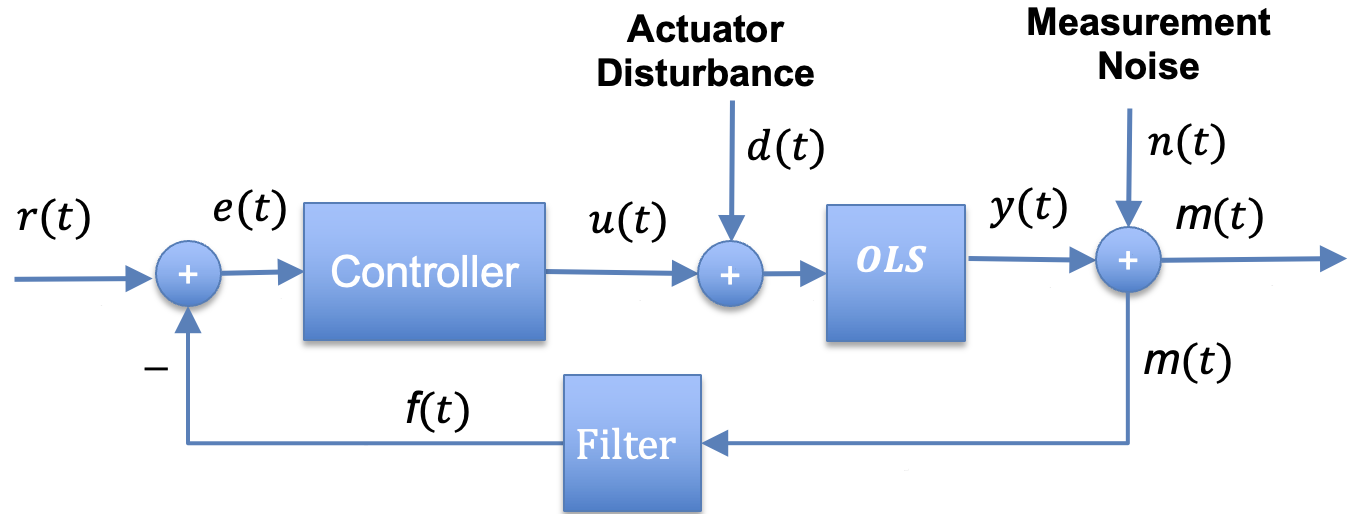

In [1]:
from IPython.display import Image
Image("closed_loop_system.png", width = 600, height = 300)

# Preliminaries

In [2]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

In [6]:
# This class captures the results of a designing a closed loop system
class DesignResult(object):
    def __init__(self, grm=None, gnm=None, params=None, det=None, op_range=None):
        """
        Parameters
        ----------
        grm: control.TransferFunction
        gnm: control.TransferFunction
        params: lmfit.Parameters
        det: lmfit.MinimizerResult
        op_range: [float, float] - operating range for OLS
        
        """
        self.grm = grm
        self.gnm = gnm
        self.params = params
        self.det = det
        self.op_range = op_range
        
    def __repr__(self):
        return ""

## ``plotSys``

In [7]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "NonlinearIOSystem" in str(type(sys)):
        is_nonlinear = True
    else:
        is_nonlinear = False
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


## ``makeCLTransferFunctions``

In [8]:
# grm: G_RM
# gnm: G_NM
# gf: Filter
# gc: Controller
# go: OLS
CLTransferFunctions = collections.namedtuple("CLTransferFunctions",
      "grm gnm gc gf go")
def makeCLTransferFunctions(gO_tf, params):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float
        kI: float
        kF: float (a value <= 0 indicates there is no filter)
    
    Returns
    -------
    CLTransferFunctions
    """
    # Extract the parameters
    kP = params["kP"].value
    kI = params["kI"].value
    kF = params["kF"].value # a value of 0 indicates that there is no filter
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
    # Construct Filter
    if kF > 0:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, sys2=gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    #
    return CLTransferFunctions(grm=gRM_tf, gnm=gNM_tf, gc=gC_tf, gf=gF_tf, go=gO_tf)
#
is_plot = False
tf = control.TransferFunction([1], [1, 1])
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kF", value=1)
cltf = makeCLTransferFunctions(tf, params)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
plot_response = plotSys(cltf.grm, is_plot=is_plot)
plot_response = plotSys(cltf.gnm, is_plot=is_plot)
print("OK!")

OK!


## ``designClosedLoop``

In [9]:
def designClosedLoop(open_loop_tf, is_filter=True, amp=1, kmax=1e4):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    
    Paramters
    ---------
    open_loop_tf: control.TransferFunction (OLS transfer function)
    is_filter: bool (include the filter)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    """
    times = np.linspace(0, 10, 100)
    step_inputs = np.repeat(1, len(times))
    ideal_step_outputs = step_inputs
    noise_inputs = amp*np.sin(5*times) # Sinusoid input
    ideal_noise_outputs = np.repeat(0, len(times))
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
        # Calculate residuals for a step response
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        step_residuals = ideal_step_outputs - step_est
        # Calculate residuals for a sinusoidal noise input
        _, sinusoid_est = control.forced_response(gNM_tf, T=times, U=noise_inputs)
        sinusoid_residuals = ideal_noise_outputs - sinusoid_est
        #
        return step_residuals + sinusoid_residuals
    #
    def calculateOperatingRange(params):
        """
        Calculates the operating range for the closed loop system designed with parameters
        
        Parameters
        ----------
        params: lmfit.Parameters
        
        Returns
        -------
        float, float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf, gC_tf = (cltf.grm, cltf.gnm, cltf.gc)
        #######
        # Step
        #######
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        # Calculate input to controller
        ctl_inputs = step_inputs - step_est
        # Calculate controller output
        _, step_outputs = control.forced_response(gC_tf, T=times, U=ctl_inputs)
        #######
        # Noise
        #######
        # Calculate input to controller
        _, noise_est = control.forced_response(gRM_tf, T=times, U=noise_inputs)
        # Calculate input to controller
        ctl_inputs = noise_inputs - noise_est
        _, noise_outputs = control.forced_response(gC_tf, T=times, U=step_inputs)
        # Calculate operating range, the extreme values of inputs to the open loop system
        ols_inputs = np.append(step_outputs, noise_outputs)
        op_range = np.min(ols_inputs), np.max(ols_inputs)
        return op_range
    # 
    params = lmfit.Parameters()
    params.add("kP", value=1, min=0, max=kmax)
    params.add("kI", value=1, min=0, max=kmax)
    params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    cltf = makeCLTransferFunctions(gO_tf, new_params)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    op_range = calculateOperatingRange(new_params)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result,
                                op_range=op_range)
    return design_result

# Tests
gO_tf = control.TransferFunction([1], [1, 1])
design_result = designClosedLoop(gO_tf, kmax=1e6, amp=10)
assert(isinstance(design_result.grm, control.TransferFunction))
assert(design_result.op_range[0] <= design_result.op_range[1])
print("OK!")

OK!


## ``plotDesignResult``

In [10]:
# Plots of the transfer functions
def plotDesignResult(design_result, ax=None, end_time=50, title="", is_plot=True, **kwargs):
    """
    Plots a DesignResult.
    
    Parameters
    ----------
    design_result: DesignResult
    ax: Matplotlib.Axes
    end_time: float
    is_plot: bool
    kwargs: dict (other plotting options)
    """
    if ax is None:
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (3, 3)
        _, ax = plt.subplots(1, figsize=figsize)
    times = np.linspace(0, end_time, 2000)
    plot_result1 = plotSys(design_result.grm, forced_input=1, times=times, ax=ax,
                         is_legend=False)
    plot_result2 = plotSys(design_result.gnm, forced_input=np.sin(5*times), times=times, 
            is_legend=False, ax=ax)
    if "ylim" in kwargs.keys():
        ylim = kwargs["ylim"]
    else:
        ylim = ax.set_ylim()
    xpos = end_time*1.1
    yspan = ylim[1] - ylim[0]
    ypos1 = ylim[1] - 0.1*yspan
    ypos2 = ypos1 - 0.2*yspan
    ax.text(xpos, ypos1, "G_RM", c="blue")
    ax.text(xpos, ypos2, "G_NM", c="orange")
    ax.set_ylim(ylim)
    ax.set_title(title)
    if not is_plot:
        plt.close()
 
# Tests
plotDesignResult(design_result, kmax=1, figsize= (2,2), is_plot=False, end_time=5)
print("OK!")

OK!


# Models

## Linear

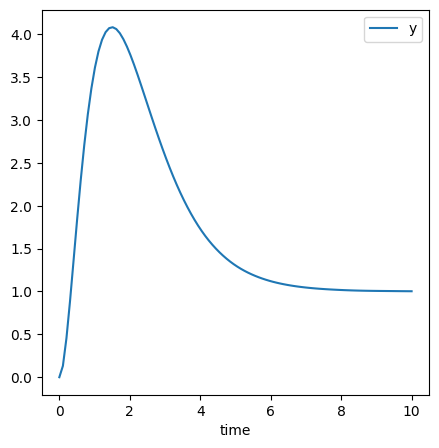

In [11]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

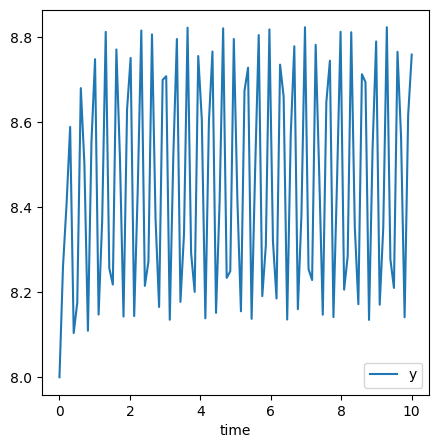

In [12]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

In [13]:
print(ctlsb.antimony)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Step 1. Problem Statement & Control Objectives

# Step 2. System Identification

# Step 3. Control Design Using Computational Optimization

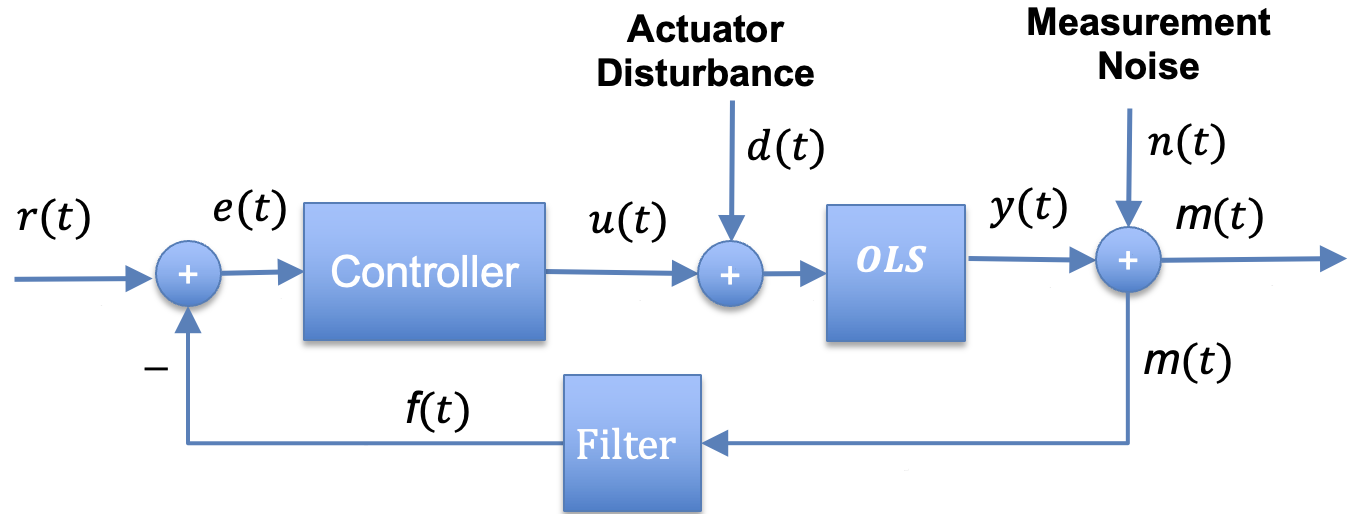

In [14]:
Image("closed_loop_system.png", width = 400, height = 200)

## Problem statement

Find $k_P$, $k_I$, $k_F$ that minimize the sum of the following:
* unit step - step response of $G_{RM} (s)$
* 0 - response of $G_{NM} (s)$ to a sinusoidal input

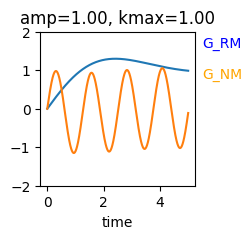

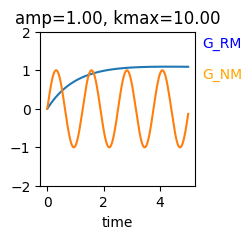

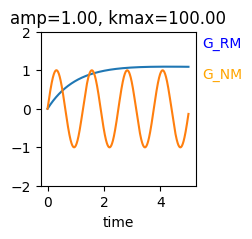

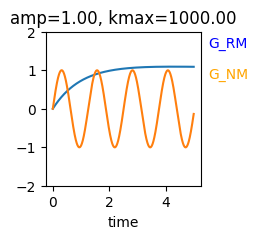

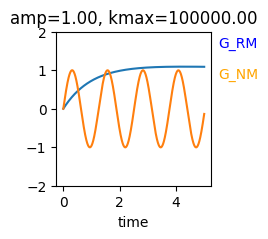

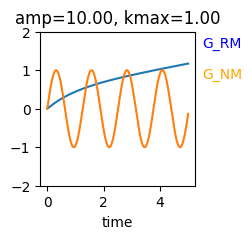

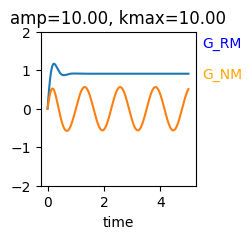

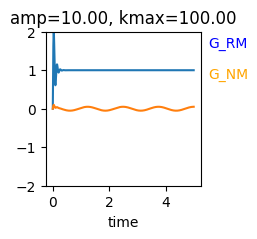

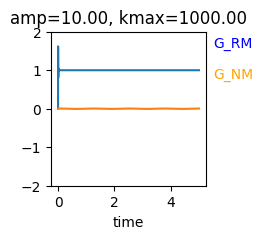

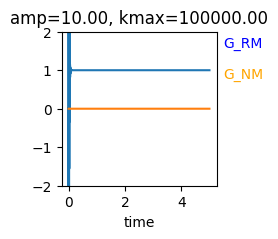

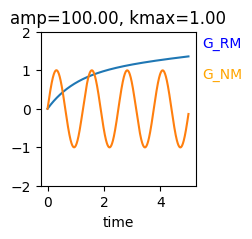

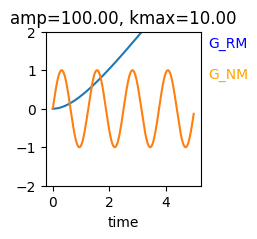

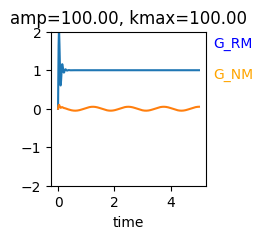

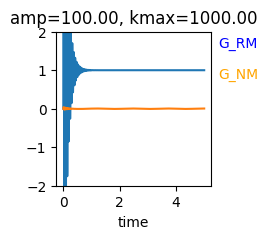

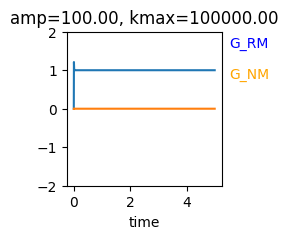

In [15]:
# Explore designs
kmaxs = [1, 10, 1e2, 1e3, 1e5]
amps = [1, 10, 100]
for amp in amps:
    for kmax in kmaxs:
        design_result = designClosedLoop(gO_tf, kmax=kmax, amp=amp)
        title = "amp=%2.2f, kmax=%2.2f" % (amp, kmax)
        plotDesignResult(design_result, figsize=(2,2), ylim=[-2, 2], title=title, kmax=kmax, end_time=5)

# Step 4. Testbed evaluations

## Implementation

## Evaluation & tuning

# Step 5. Discussion

1. Operating range
1. How well are control objectives achieved
1. Value provided by control design